### Lecture 3

During this jupyter notebook we will use the techniques aquires during the first two weeks to use multiple linear regression for predictive tasks. We will find optimal solutions by using the learning descent algorithm and then see a practical overview of OLS estimations.

In [1]:
# If you enconunter a ModuleNotFoundError run: 
# !pip install pandas numpy matplotlib statsmodels


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy, math

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression


# For OLS Regression Analysis
import statsmodels.api as sm


In [2]:
# We will start by loading our kaggle data set

data_path = "./kaggle/train.csv" # This is the path where the data is located
data = pd.read_csv(data_path)
data

# Feel free to have a quick look.

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In [3]:
# Since some variables have non-numeric values, we will only select the ones that do.
# We select columns that include integers or floats (decimals)

df_num = data.select_dtypes(include = ['float64', 'int64'])
df_num = df_num.dropna()

In [4]:
x_train = df_num.iloc[:,1:-1]
y_train = df_num['SalePrice']
X_features = x_train.columns
x_train = np.array(x_train)
y_train = np.array(y_train)
print(x_train)
print(y_train)
                   

[[6.000e+01 6.500e+01 8.450e+03 ... 0.000e+00 2.000e+00 2.008e+03]
 [2.000e+01 8.000e+01 9.600e+03 ... 0.000e+00 5.000e+00 2.007e+03]
 [6.000e+01 6.800e+01 1.125e+04 ... 0.000e+00 9.000e+00 2.008e+03]
 ...
 [7.000e+01 6.600e+01 9.042e+03 ... 2.500e+03 5.000e+00 2.010e+03]
 [2.000e+01 6.800e+01 9.717e+03 ... 0.000e+00 4.000e+00 2.010e+03]
 [2.000e+01 7.500e+01 9.937e+03 ... 0.000e+00 6.000e+00 2.008e+03]]
[208500 181500 223500 ... 266500 142125 147500]


That looks much better! This will mean we will use 35 features to predict the Sale Price


### The function that we are trying to estimate

The model's prediction with multiple variables is given by the linear model:

$$ f_{\mathbf{w},b}(\mathbf{x}) =  w_0x_0 + w_1x_1 +... + w_{n-1}x_{n-1} + b \tag{1}$$

This means, we have to estimate the $n+1$ parameters: $w_0, w_1,...,w_{n-1},b$

In vector notation, this is writen:
$$ f_{\mathbf{w},b}(\mathbf{x}) = \mathbf{w} \cdot \mathbf{x} + b  \tag{2} $$ 
where $\cdot$ is a vector `dot product`

The numpy library can compute the dot product very efficiently by using np.dot()

### Another Example of how this can really useful

Imagine predicting a patient's cancer risk. Each variable could represent factors like age, genetic markers, lifestyle habits, or test results. These variables are represented by $\mathbf{x}=(x_0, x_1,...x_{n+1})$. The model learns how each factor contributes to the overall risk, adjusting weights based on how much each one typically correlates with cancer.

Once trained, the model can analyze a new patient’s data to provide an estimated cancer risk level. This helps doctors identify high-risk patients early, allowing for quicker intervention and personalized care. Everything we have to do is give a patients variables $\mathbf{x}=(x_0, x_1,...x_{n+1})$ to a pretrained model (where we estimated w and b) and $f(\mathbf{x})$ will be our prediction (In this example a probability between 0 and 1).

Therefore, if you can think of any interesting problem yourself and have the data, don't be afraid, go for it!

In [5]:
# Let's start by defining our f(x)

def f(x):
    p = np.dot(x, w) + b # This is our prediction    
    return p          

### **Cost function**

The equation for the cost function with multiple variables $J(\mathbf{w},b)$ is:
$$J(\mathbf{w},b) = \frac{1}{2m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)})^2 \tag{3}$$ 
where:
$$ f_{\mathbf{w},b}(\mathbf{x}^{(i)}) = \mathbf{w} \cdot \mathbf{x}^{(i)} + b  \tag{4} $$ 

In [6]:
def compute_cost(X, y, w, b): 
    """
    compute cost
    Args:
      X (ndarray (m,n)): Data, m examples with n features
      y (ndarray (m,)) : target values
      w (ndarray (n,)) : model parameters  
      b (scalar)       : model parameter
      
    Returns:
      cost (scalar): cost
    """
    m = X.shape[0]
    cost = 0.0
    for i in range(m):                                
        f_wb_i = np.dot(X[i], w) + b           #(n,)(n,) = scalar (see np.dot)
        cost = cost + (f_wb_i - y[i])**2       #scalar
    cost = cost / (2 * m)                      #scalar    
    return cost

### **Gradient Descent**

The gradient descent algorithm is the same for multiple variables. We just have to adjust more parameters by the same rule.

Gradient descent for multiple variables:

$$\begin{align*} \text{repeat}&\text{ until convergence:} \; \lbrace \newline\;
& w_j = w_j -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial w_j} \tag{5}  \; & \text{for j = 0..n-1}\newline
&b\ \ = b -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial b}  \newline \rbrace
\end{align*}$$

where, n is the number of features, parameters $w_j$,  $b$, are updated simultaneously and where  

$$
\begin{align}
\frac{\partial J(\mathbf{w},b)}{\partial w_j}  &= \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)})x_{j}^{(i)} \tag{6}  \\
\frac{\partial J(\mathbf{w},b)}{\partial b}  &= \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)}) \tag{7}
\end{align}
$$
* m is the number of training examples in the data set

    
*  $f_{\mathbf{w},b}(\mathbf{x}^{(i)})$ is the model's prediction, while $y^{(i)}$ is the target value

In [7]:
# Start by computing our partial derivatives
def compute_gradient(X, y, w, b): 
    """
    Computes the gradient for linear regression 
    Args:
      X (ndarray (m,n)): Data, m examples with n features
      y (ndarray (m,)) : target values
      w (ndarray (n,)) : model parameters  
      b (scalar)       : model parameter
      
    Returns:
      dj_dw (ndarray (n,)): The gradient of the cost w.r.t. the parameters w. 
      dj_db (scalar):       The gradient of the cost w.r.t. the parameter b. 
    """
    m,n = X.shape           #(number of examples, number of features)
    dj_dw = np.zeros((n,))
    dj_db = 0.

    for i in range(m):                             
        err = (np.dot(X[i], w) + b) - y[i]   
        for j in range(n):                         
            dj_dw[j] = dj_dw[j] + err * X[i, j]    
        dj_db = dj_db + err                        
    dj_dw = dj_dw / m                                
    dj_db = dj_db / m                                
        
    return dj_db, dj_dw

def gradient_descent(X, y, w_in, b_in, cost_function, gradient_function, alpha, num_iters): 
    """
    Performs batch gradient descent to learn theta. Updates theta by taking 
    num_iters gradient steps with learning rate alpha
    
    Args:
      X (ndarray (m,n))   : Data, m examples with n features
      y (ndarray (m,))    : target values
      w_in (ndarray (n,)) : initial model parameters  
      b_in (scalar)       : initial model parameter
      cost_function       : function to compute cost
      gradient_function   : function to compute the gradient
      alpha (float)       : Learning rate
      num_iters (int)     : number of iterations to run gradient descent
      
    Returns:
      w (ndarray (n,)) : Updated values of parameters 
      b (scalar)       : Updated value of parameter 
      """
    
    # An array to store cost J and w's at each iteration primarily for graphing later
    J_history = []
    w = copy.deepcopy(w_in)  #avoid modifying global w within function
    b = b_in
    
    for i in range(num_iters):

        # Calculate the gradient and update the parameters
        dj_db,dj_dw = gradient_function(X, y, w, b)   ##None

        # Update Parameters using w, b, alpha and gradient
        w = w - alpha * dj_dw               ##None
        b = b - alpha * dj_db               ##None
      
        # Save cost J at each iteration
        if i<100000:      # prevent resource exhaustion 
            J_history.append( cost_function(X, y, w, b))

        # Print cost every at intervals 10 times or as many iterations if < 10
        if i% math.ceil(num_iters / 10) == 0:
            print(f"Iteration {i:4d}: Cost {J_history[-1]:8.2f}   ")
        
    return w, b, J_history #return final w,b and J history for graphing

In [8]:
# Initialise random w and b

w_init = np.array([0.] * 36) # Since we are looking at 36 different features
b_init = 0.
print(f"Initial w: {w_init.shape}")
print(f"Initial b: {type(b_init)}")

Initial w: (36,)
Initial b: <class 'float'>


### **Data normalisation**

### z-score normalization 
After z-score normalization, all features will have a mean of 0 and a standard deviation of 1.

To implement z-score normalization, adjust your input values as shown in this formula:
$$x^{(i)}_j = \dfrac{x^{(i)}_j - \mu_j}{\sigma_j} \tag{4}$$ 
where $j$ selects a feature or a column in the $\mathbf{X}$ matrix. $µ_j$ is the mean of all the values for feature (j) and $\sigma_j$ is the standard deviation of feature (j).
$$
\begin{align}
\mu_j &= \frac{1}{m} \sum_{i=0}^{m-1} x^{(i)}_j \tag{5}\\
\sigma^2_j &= \frac{1}{m} \sum_{i=0}^{m-1} (x^{(i)}_j - \mu_j)^2  \tag{6}
\end{align}
$$

>**Implementation Note:** When normalizing the features, it is important
to store the values used for normalization - the mean value and the standard deviation used for the computations. After learning the parameters
from the model, we often want to predict the prices of houses we have not
seen before. Given a new x value (living room area and number of bed-
rooms), we must first normalize x using the mean and standard deviation
that we had previously computed from the training set.

**Implementation**

In [9]:
def zscore_normalize_features(X):
    mu = np.mean(X, axis=0)                
    sigma = np.std(X, axis=0)                  
    X_norm = (X - mu) / sigma      

    return (X_norm, mu, sigma)

In [10]:
# normalize the original features
X_norm, X_mu, X_sigma = zscore_normalize_features(x_train)

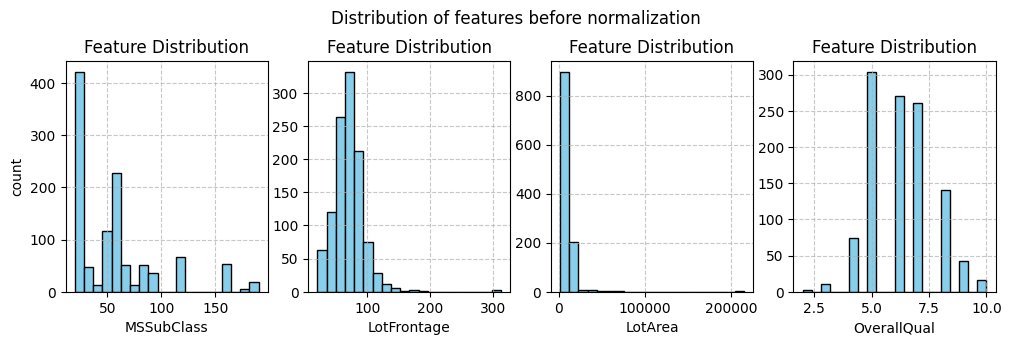

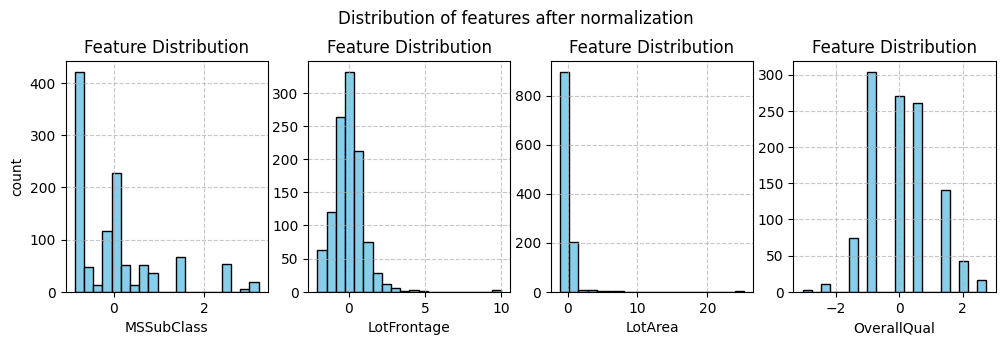

In [11]:
# Visualization of normalization (Not necessary)

def norm_plot(ax, data, bins=20):
    """
    Plots a histogram of the provided data on the given axis.
    
    Parameters:
    - ax: The axis on which to plot the histogram.
    - data: The data array for the feature to be plotted.
    - bins: The number of bins for the histogram. Default is 20.
    """
    ax.hist(data, bins=bins, color='skyblue', edgecolor='black')
    ax.set_title("Feature Distribution")
    ax.grid(True, linestyle='--', alpha=0.7)

fig,ax=plt.subplots(1, 4, figsize=(12, 3))
for i in range(len(ax)):
    norm_plot(ax[i],x_train[:,i],)
    ax[i].set_xlabel(X_features[i])
ax[0].set_ylabel("count");
fig.suptitle("Distribution of features before normalization", y = 1.05)
plt.show()
fig,ax=plt.subplots(1,4,figsize=(12,3))
for i in range(len(ax)):
    norm_plot(ax[i],X_norm[:,i],)
    ax[i].set_xlabel(X_features[i])
ax[0].set_ylabel("count"); 
fig.suptitle("Distribution of features after normalization", y = 1.05)

plt.show()

In [12]:
# Run Gradient Descent.

# initialize parameters
initial_w = np.zeros_like(w_init)
initial_b = 0.
# some gradient descent settings
iterations = 20000 # Feel free to reduce this number if this is a bit slow
alpha = 5.0e-4
# run gradient descent 
w_final, b_final, J_hist = gradient_descent(X_norm, y_train, initial_w, initial_b,
                                                    compute_cost, compute_gradient, 
                                                    alpha, iterations)
print(f"b,w found by gradient descent: {b_final:0.2f},{w_final} ")
m,_ = X_norm.shape


Iteration    0: Cost 20611384018.74   
Iteration 2000: Cost 3047540919.22   
Iteration 4000: Cost 1001164728.02   
Iteration 6000: Cost 715416066.72   
Iteration 8000: Cost 671659167.06   
Iteration 10000: Cost 662795453.45   
Iteration 12000: Cost 659843652.40   
Iteration 14000: Cost 658367110.02   
Iteration 16000: Cost 657483789.18   
Iteration 18000: Cost 656916519.26   
b,w found by gradient descent: 185497.75,[-8011.41949503 -2554.88144257  4371.01684486 25300.23441283
  4971.24485624  7414.6478549   3530.17191891  6203.30658114
  4930.42056713   138.71580287 -1017.24755316  4203.24404008
  7060.34994443  8485.56937076   249.84729751 12331.62047256
  4557.03199214   566.25084138  4001.4751966    264.02161654
 -7473.23854297 -4736.50310288  8860.92989084  3198.91077193
  -412.32382937  9937.32513012  2198.63407278  2656.09106672
  -277.77367228   265.29134584  1002.93366631  3310.6169966
 -2516.37594624  -682.08787893  -527.42969216  -384.33861248] 


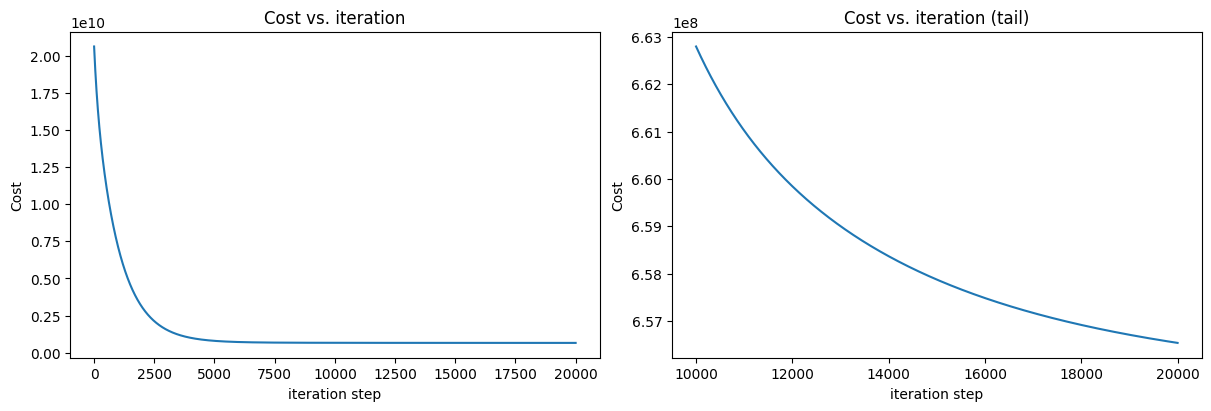

In [13]:
# plot cost versus iteration  
fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True, figsize=(12, 4))
ax1.plot(J_hist)
ax2.plot(10000 + np.arange(len(J_hist[10000:])), J_hist[10000:])
ax1.set_title("Cost vs. iteration");  ax2.set_title("Cost vs. iteration (tail)")
ax1.set_ylabel('Cost')             ;  ax2.set_ylabel('Cost') 
ax1.set_xlabel('iteration step')   ;  ax2.set_xlabel('iteration step') 
plt.show()

In [14]:
# Predictions vs Real Values

for i in range(m):
    print(f"prediction: {np.dot(X_norm[i], w_final) + b_final:0.2f}, target value: {y_train[i]}")

prediction: 232010.00, target value: 208500
prediction: 196475.96, target value: 181500
prediction: 225624.80, target value: 223500
prediction: 201274.36, target value: 140000
prediction: 298964.64, target value: 250000
prediction: 174889.98, target value: 143000
prediction: 275587.73, target value: 307000
prediction: 186232.86, target value: 129900
prediction: 75564.74, target value: 118000
prediction: 116271.31, target value: 129500
prediction: 348580.97, target value: 345000
prediction: 240005.09, target value: 279500
prediction: 155573.50, target value: 132000
prediction: 80914.57, target value: 90000
prediction: 155884.42, target value: 159000
prediction: 119455.28, target value: 139000
prediction: 299687.91, target value: 325300
prediction: 135745.49, target value: 139400
prediction: 252103.56, target value: 230000
prediction: 138876.84, target value: 129900
prediction: 270981.08, target value: 256300
prediction: 126914.48, target value: 134800
prediction: 285101.68, target value

### Question 1

The data path to the test data set is: data_path = "./kaggle/test.csv"

We can use that data to make predictions (it does not include the SalePrice variable).

- Step 1) Download the data set and select the relevant rows (only int and float)
- Step 2) Normalise your input data
- Step 3) Take the dot product of the input features and the weights to obtain predictions
- Step 4) This can be your first Kaggle submission!


Iteration 0: Cost 18866277539.967087
Iteration 2000: Cost 589266863.1131732
Iteration 4000: Cost 589192512.0262545
Iteration 6000: Cost 589191246.8748986
Iteration 8000: Cost 589191220.4703593
Iteration 10000: Cost 589191219.884279
Iteration 12000: Cost 589191219.871034
Iteration 14000: Cost 589191219.8707333
Iteration 16000: Cost 589191219.8707263
Iteration 18000: Cost 589191219.8707262
Final weights: [ -454.27871523 -7662.7147097  -1246.06260023  4273.49400775
 23918.00300023  5206.53944603  8193.2577633   2785.16763178
  5649.68422505  4328.50271551  -234.73829897  -174.79312022
  4237.73910542  8510.47310955  9567.70086619   -97.72250421
 14200.08569176  4861.38141099   478.64590475  1905.80717472
  -941.35400573 -8221.00663423 -2716.51082793  8257.62106047
  2544.22568102  2930.39130908  8413.43560902  -897.83509991
  2990.78131575  -192.77006523   720.21972013   578.75133819
  3119.38333036 -1138.06248177  -365.20808184  -122.23216969
 -1030.77708786]
Final bias: 180921.195890409

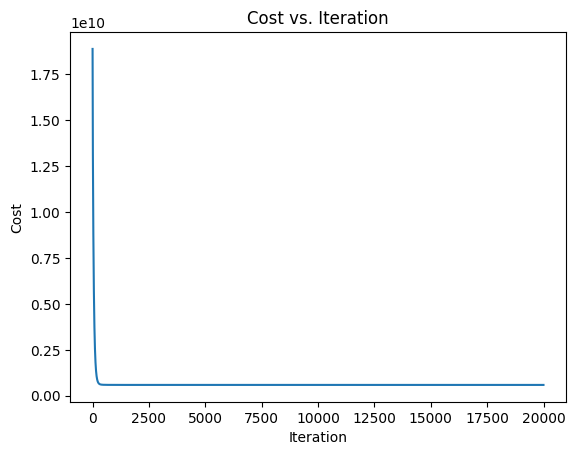

First 5 predictions: [120290.15527846 159133.58160912 179280.35086667 203726.34288542
 194597.87742618]


In [15]:
import numpy as np
import pandas as pd

# Load training data
train_data_path = "./kaggle/train.csv"
train_df = pd.read_csv(train_data_path)

# Load test data
data_path = "./kaggle/test.csv"
test_df = pd.read_csv(data_path)

# Select only numerical data
train_numeric = train_df.select_dtypes(include=['int64', 'float64'])
test_numeric = test_df.select_dtypes(include=['int64', 'float64'])

# Exclude 'SalePrice' from training data (use only features)
X_train = train_numeric.drop(columns=['SalePrice'])  # Exclude 'SalePrice' as it's the target variable
y_train = train_numeric['SalePrice']  # 'SalePrice' is the target variable to predict

# Select only the columns from the test data that match the training data
X_test = test_numeric[X_train.columns]  # Select the same columns as in training data

# Fill missing values with the mean of each column
X_train_filled = X_train.fillna(X_train.mean())
X_test_filled = X_test.fillna(X_train.mean())  # Fill missing values in test data with training data mean

# Normalize the features (standardize features to have zero mean and unit variance)
def zscore_normalize_features(X):
    mu = np.mean(X, axis=0)                
    sigma = np.std(X, axis=0)                  
    X_norm = (X - mu) / sigma      
    return (X_norm, mu, sigma)

X_train_norm, X_train_mu, X_train_sigma = zscore_normalize_features(X_train_filled)
X_test_norm, X_test_mu, X_test_sigma = zscore_normalize_features(X_test_filled)

# Gradient Descent Functions

def compute_cost(X, y, w, b): 
    """
    Computes the cost for linear regression using MSE.
    """
    m = X.shape[0]
    cost = (1 / (2 * m)) * np.sum((np.dot(X, w) + b - y) ** 2)
    return cost

def compute_gradient(X, y, w, b):
    """
    Computes the gradient of the cost function with respect to w and b.
    """
    m = X.shape[0]
    dj_dw = (1 / m) * np.dot(X.T, (np.dot(X, w) + b - y))
    dj_db = (1 / m) * np.sum(np.dot(X, w) + b - y)
    return dj_dw, dj_db

def gradient_descent(X, y, w, b, alpha, iterations):
    """
    Performs gradient descent to optimize the weights and bias.
    """
    cost_history = []
    
    for i in range(iterations):
        dj_dw, dj_db = compute_gradient(X, y, w, b)
        w -= alpha * dj_dw
        b -= alpha * dj_db
        
        # Save cost at each iteration for later plotting
        cost = compute_cost(X, y, w, b)
        cost_history.append(cost)
        
        # Print progress every 200 iterations
        if i % 2000 == 0:
            print(f"Iteration {i}: Cost {cost}")
    
    return w, b, cost_history

# Initialize weights and bias
w_init = np.zeros(X_train_norm.shape[1])
b_init = 0.0

# Set hyperparameters
iterations = 20000
alpha = 0.01

# Run gradient descent to find the optimal weights and bias
w_final, b_final, J_hist = gradient_descent(X_train_norm, y_train, w_init, b_init, alpha, iterations)

print(f"Final weights: {w_final}")
print(f"Final bias: {b_final}")

# Plot cost vs. iteration to visualize convergence
plt.plot(J_hist)
plt.title("Cost vs. Iteration")
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

# Make predictions using the optimized weights and bias
y_pred = np.dot(X_test_norm, w_final) + b_final

# Print the first 5 predictions
print(f"First 5 predictions: {y_pred[:5]}")


In [16]:
# Load training data
train_data_path = "./kaggle/train.csv"
train_df = pd.read_csv(train_data_path)

# Load test data
data_path = "./kaggle/test.csv"
test_df = pd.read_csv(data_path)

# Select only numerical data
train_numeric = train_df.select_dtypes(include=['int64', 'float64'])
test_numeric = test_df.select_dtypes(include=['int64', 'float64'])

# Exclude 'SalePrice' from training data (use only features)
X_train = train_numeric.drop(columns=['SalePrice'])  # Exclude 'SalePrice' as it is the target variable
y_train = train_numeric['SalePrice']  # 'SalePrice' is the target variable to predict

# Select only the columns from the test data that match the training data
X_test = test_numeric[X_train.columns]  # Select the same columns as in training data

# Fill missing values with the mean of each column
X_train_filled = X_train.fillna(X_train.mean())
X_test_filled = X_test.fillna(X_train.mean())  # Fill missing values in test data with training data mean

# Normalise the data
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train_filled)
X_test_norm = scaler.transform(X_test_filled)  # Apply the same scaling to test data

# Train the model
model = LinearRegression()
model.fit(X_train_norm, y_train)  # Train the model with the training data

# Make predictions
y_pred = model.predict(X_test_norm)  # Generate predictions on the test data

print(y_pred)

# Calculate the mean and standard deviation of the training data target variable (SalePrice)
y_train_mean = np.mean(y_train)  # Mean of SalePrice in the training data
y_train_std = np.std(y_train)    # Standard deviation of SalePrice in the training data

# Revert the normalised predictions back to the original scale of SalePrice
y_pred_original = (y_pred * y_train_std) + y_train_mean


[115929.34416365 150565.652163   171987.29326869 ... 168873.77583289
  98943.2854489  250488.61830365]


To summarise and contrast the two approaches:

The first method involves implementing **Gradient Descent** manually. Here, the model parameters (weights and bias) are updated iteratively using the gradients of the cost function (Mean Squared Error). This method provides more control over the optimisation process, as the user can modify the learning rate and the number of iterations, allowing for detailed tuning of the model's training behaviour. While this approach offers greater transparency and insight into the model's learning process, it requires more code and careful adjustment of hyperparameters such as learning rate and iterations to avoid overfitting or underfitting. 

In contrast, the second method uses **scikit-learn's `LinearRegression`**, which directly handles the fitting of a linear model with built-in functions for data normalisation and prediction. This method is straightforward and efficient, using `StandardScaler` for feature normalisation and automatically handling missing values. The process involves training the model on normalised data and then reversing the normalisation to return predictions in the original scale. This method is highly optimised for practical use but offers limited insight into the underlying mechanics of the learning process.

In conclusion, scikit-learn's method is preferable for quick, robust modelling, while the gradient descent approach is better suited for understanding and customising the model training process.

In [17]:
# Prepare the submission file
submission = pd.DataFrame({
    'Id': test_df['Id'],  # Use the 'Id' column from the test set
    'SalePrice': y_pred_original  # Use the predicted 'SalePrice'
})

# Save the predictions to a CSV file
submission.to_csv('./kaggle_submission.csv', index=False)

### Question 2

Explore solving this problem using OLS. I have added one of Yusuf's lectures (last year), that covered this topic. Below is an example. Can you solve it using Yusuf's method though?

In [18]:
# Load the dataset
train_df = pd.read_csv('./kaggle/train.csv')

# Define the features (X) and target (y) based on specification
X = train_df[['OverallQual', 'YearBuilt', 'GrLivArea', 'TotalBsmtSF', '1stFlrSF', 'GarageArea']]
y = train_df['SalePrice']

# Add a constant (intercept) to the feature set
X_b = sm.add_constant(X)

# Fit the OLS model
ols_model = sm.OLS(y, X_b).fit()

# Get the summary as a string
summary = ols_model.summary().as_text()

# Split the summary by lines and remove the lines with Date and Time
lines = summary.split('\n')
filtered_lines = [line for line in lines if not line.startswith("Date:") and not line.startswith("Time:")]

# Print the filtered summary
print('\n'.join(filtered_lines))

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.768
Model:                            OLS   Adj. R-squared:                  0.767
Method:                 Least Squares   F-statistic:                     801.4
No. Observations:                1460   AIC:                         3.497e+04
Df Residuals:                    1453   BIC:                         3.501e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -7.542e+05   8.32e+04     -9.066      0.000   -9.17e+05   -5.91e+05
OverallQual  2.134e+04   1152.660     18.511      0.000    1.91e+04    2.36e+04
YearBuilt     342.2151     43.674      7.836    

The OLS regression model explains 76.8% of the variation in `SalePrice`, with a highly significant F-statistic of 801.4 and p-value of 0.00. The coefficients for the key predictors, including `OverallQual`, `YearBuilt`, `GrLivArea`, `TotalBsmtSF`, `1stFlrSF`, and `GarageArea`, are all statistically significant, with p-values below 0.05, indicating a strong relationship with the target variable. The 95% confidence intervals for these coefficients suggest reliable estimates. The Durbin-Watson statistic of 1.986 indicates no significant autocorrelation in the residuals, though the large condition number (2.51e+05) points to potential multicollinearity. To improve the model, further diagnostics such as checking for heteroscedasticity, calculating Variance Inflation Factors (VIF), and identifying influential points using methods like Cook's distance are recommended.